In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Cropping2D, ZeroPadding2D

import numpy as np
import matplotlib.pyplot as plt


#Loading the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
images_path = '/content/drive/My Drive/data/images/'
labels_path = '/content/drive/My Drive/data/labels/'

In [ ]:
!pip install tifffile

In [ ]:
import os
from PIL import Image
import tifffile
import numpy as np
import tensorflow as tf

# Define paths
images_path = '/content/drive/MyDrive/data/images'
labels_path = '/content/drive/MyDrive/data/labels'

# Load all image files (assuming .tif format for images)
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')]

# Load all label files (assuming .png format for labels)
label_files = [os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.png')]

# Sort files to ensure they match up
image_files.sort()
label_files.sort()

# Load the first image and label
image_data = tifffile.imread(image_files[0])
label_data = Image.open(label_files[0])

# Convert label data to a NumPy array
label_data = np.array(label_data)

# Convert images and labels to TensorFlow datasets
def load_data(image_files, label_files):
    images = []
    labels = []

    for img_path, lbl_path in zip(image_files, label_files):
        # Load image
        img = tifffile.imread(img_path)
        images.append(img)

        # Load and convert label image
        lbl = Image.open(lbl_path)
        lbl = np.array(lbl)
        labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load all data
images, labels = load_data(image_files, label_files)

# Create TensorFlow datasets
def preprocess_image(image, label):
    # Normalize image if necessary (example: scaling pixel values to [0,1])
    image = tf.cast(image, tf.float32) / 255.0 # Cast image to float32
    # Resize or augment if necessary
    image = tf.image.resize(image, [128, 128])  # Adjust size if needed
    # Add channel dimension to label
    label = label[..., np.newaxis]
    label = tf.image.resize(label, [128, 128])  # Adjust size if needed
    return image, label

def normalize_image(image):
    """
    Normalize image to [0, 1] range.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)

    return normalized_image

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((images, labels))  # Use separate validation data
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

#Building the U-Net Architecture

In [ ]:
def conv_block(x, n_filters):
    """Two convolutions"""
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    return x

def encoder_block(x, n_filters):
    """Conv block and max pooling"""
    x = conv_block(x, n_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p  # We will need x for the skip connections later

def decoder_block(x, skip, n_filters):
    """Upsample, skip connection, and conv block"""
    # Upsample the feature map
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)

    # Ensure the dimensions match
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        # Calculate the difference
        diff_height = skip.shape[1] - x.shape[1]
        diff_width = skip.shape[2] - x.shape[2]

        # Add padding if necessary
        x = ZeroPadding2D(padding=((0, diff_height), (0, diff_width)))(x)

    # Concatenate the feature map from encoder with the upsampled feature map
    x = concatenate([x, skip])  # skip connection
    x = conv_block(x, n_filters)
    return x

def unet_model(n_classes, img_height, img_width, img_channels):
    inputs = Input((img_height, img_width, img_channels))

    # Contraction path (encoder)
    c1, p1 = encoder_block(inputs, n_filters=64)  # c1=128x128x64, p1=64x64x64
    c2, p2 = encoder_block(p1, n_filters=128)     # c2=64x64x128, p2=32x32x128
    c3, p3 = encoder_block(p2, n_filters=256)     # c3=32x32x256, p3=16x16x256
    c4, p4 = encoder_block(p3, n_filters=512)     # c4=16x16x512, p4=8x8x512
    c5, p5 = encoder_block(p4, n_filters=1024)    # c5=8x8x1024, p5=4x4x1024

    # Bottleneck
    bridge = conv_block(p5, n_filters=1024)       # bridge=4x4x1024

    # Expansive path (decoder)
    u4 = decoder_block(bridge, c4, n_filters=512) # 8x8x512
    u3 = decoder_block(u4, c3, n_filters=256)     # 16x16x256
    u2 = decoder_block(u3, c2, n_filters=128)     # 32x32x128
    u1 = decoder_block(u2, c1, n_filters=64)      # 64x64x64

    # Output layer with one filter
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)  # 128x128x1

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
model = unet_model(
    n_classes=1,       # Single output channel (binary segmentation)
    img_height=128,
    img_width=128,
    img_channels=12
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 64, 64, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 32, 32, 128)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 16, 16, 256)    │              0 │ conv2d_47[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 8, 8, 512)      │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 4, 4, 1024)     │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)   

 Total params: 49,913,345 (190.40 MB)

 Trainable params: 49,913,345 (190.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
from keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement to wait before reducing the learning rate
    min_lr=0.001         # Minimum learning rate
)

# Fit the model with the callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[reduce_lr]
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.7008 - loss: 0.6069 - val_accuracy: 0.6889 - val_loss: 0.6121 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - accuracy: 0.7001 - loss: 0.6080 - val_accuracy: 0.6882 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.7004 - loss: 0.6063 - val_accuracy: 0.6890 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step - accuracy: 0.6997 - loss: 0.6063 - val_accuracy: 0.6903 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.7009 - loss: 0.6065 - val_accuracy: 0.6909 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.7010 - loss: 0.6052 - val_accuracy: 0.6914 - val_loss: 0.6072 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - accuracy: 0.6993 - loss: 0.6

#Evaluation

In [34]:
# Evaluate the model on the validation or test dataset
results = model.evaluate(val_ds)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7014 - loss: 0.6018
Test Loss: 0.606025218963623
Test Accuracy: 0.6883610486984253


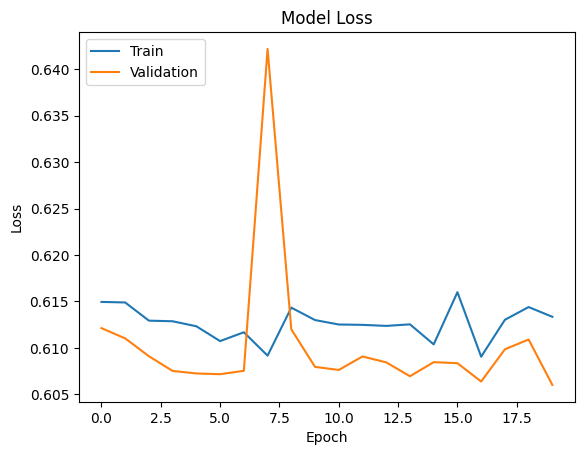

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

